In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 

df=pd.read_csv("SalesDataConsolidated - PET Preforms.csv", header=0)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        4782 non-null   object 
 1   PARTY NAME  4782 non-null   object 
 2   TYPE        4782 non-null   object 
 3   GM          4782 non-null   float64
 4   NECK        4782 non-null   object 
 5   Quantity    4780 non-null   object 
dtypes: float64(1), object(5)
memory usage: 224.3+ KB


In [4]:
print(df['GM'].unique())
print(df['NECK'].unique())

[ 9.2  13.6  18.5  32.   34.   18.6   8.9  12.6   9.6   8.6   8.45 18.2
 22.   80.    9.8  10.   12.8  17.8   8.7  19.5 ]
['ALASKA' 'PCO']


In [5]:
#Convert the dataset to correct format and remove the unwanted data
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['GM'] = pd.to_numeric(df['GM'], errors='coerce')
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df.head()

,DATE,PARTY NAME,TYPE,GM,NECK,Quantity
0,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,54.0
1,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,220.0
2,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,360.0
3,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,40.0
4,2019-06-24,M P AQUATECH,PET PREFORM,18.5,ALASKA,18.0


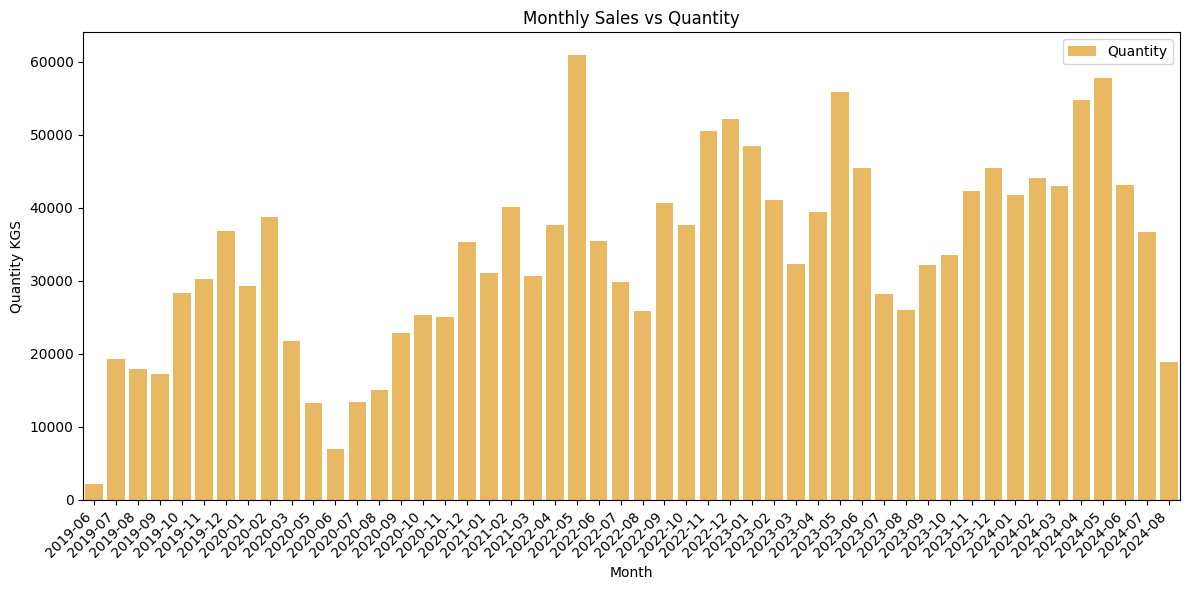

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   DATE      50 non-null     period[M]
 1   TYPE      50 non-null     object   
 2   Quantity  50 non-null     float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 1.3+ KB


In [6]:
#grouping the data monthly
monthly_grp = df.groupby([df['DATE'].dt.to_period('M'),'TYPE']).agg({'Quantity': 'sum'}).reset_index()
#create a new column for month
plt.figure(figsize=(12, 6))
sns.barplot(x='DATE', y='Quantity', data=monthly_grp, color='orange', alpha=0.7, label='Quantity')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Quantity KGS')
plt.title('Monthly Sales vs Quantity')
plt.legend()
plt.tight_layout()
plt.show()
monthly_grp.info()

# Conclusion from this graphical analysis

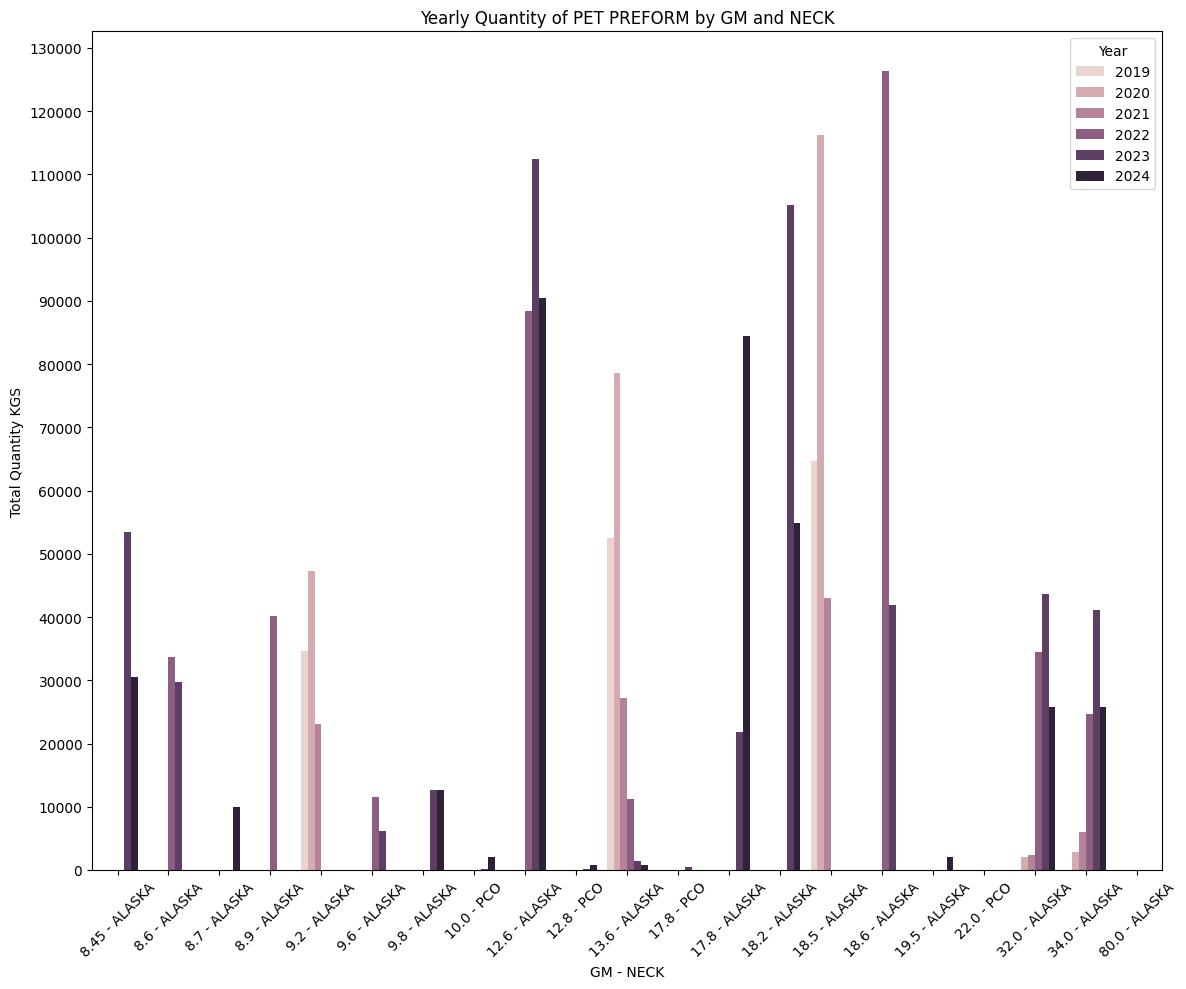

In [7]:
#grouping the data yearly
df['Year'] = df['DATE'].dt.year
yearly_grp = df.groupby(['Year','GM','NECK'])['Quantity'].sum().reset_index()
yearly_grp['GM_NECK'] = yearly_grp['GM'].astype(str) + ' - ' + yearly_grp['NECK']
yearly_grp = yearly_grp.sort_values(by='GM')

plt.figure(figsize=(12, 10))
sns.barplot(x='GM_NECK', y='Quantity', hue='Year', data=yearly_grp)
plt.xlabel('GM - NECK')
plt.ylabel('Total Quantity KGS')
plt.title('Yearly Quantity of PET PREFORM by GM and NECK')
plt.xticks(rotation=45)
y_ticks = np.arange(0, yearly_grp['Quantity'].max() + 10000, 10000) 
plt.yticks(y_ticks)
plt.tight_layout()
plt.show()

# Conclusion from this graphical analysis


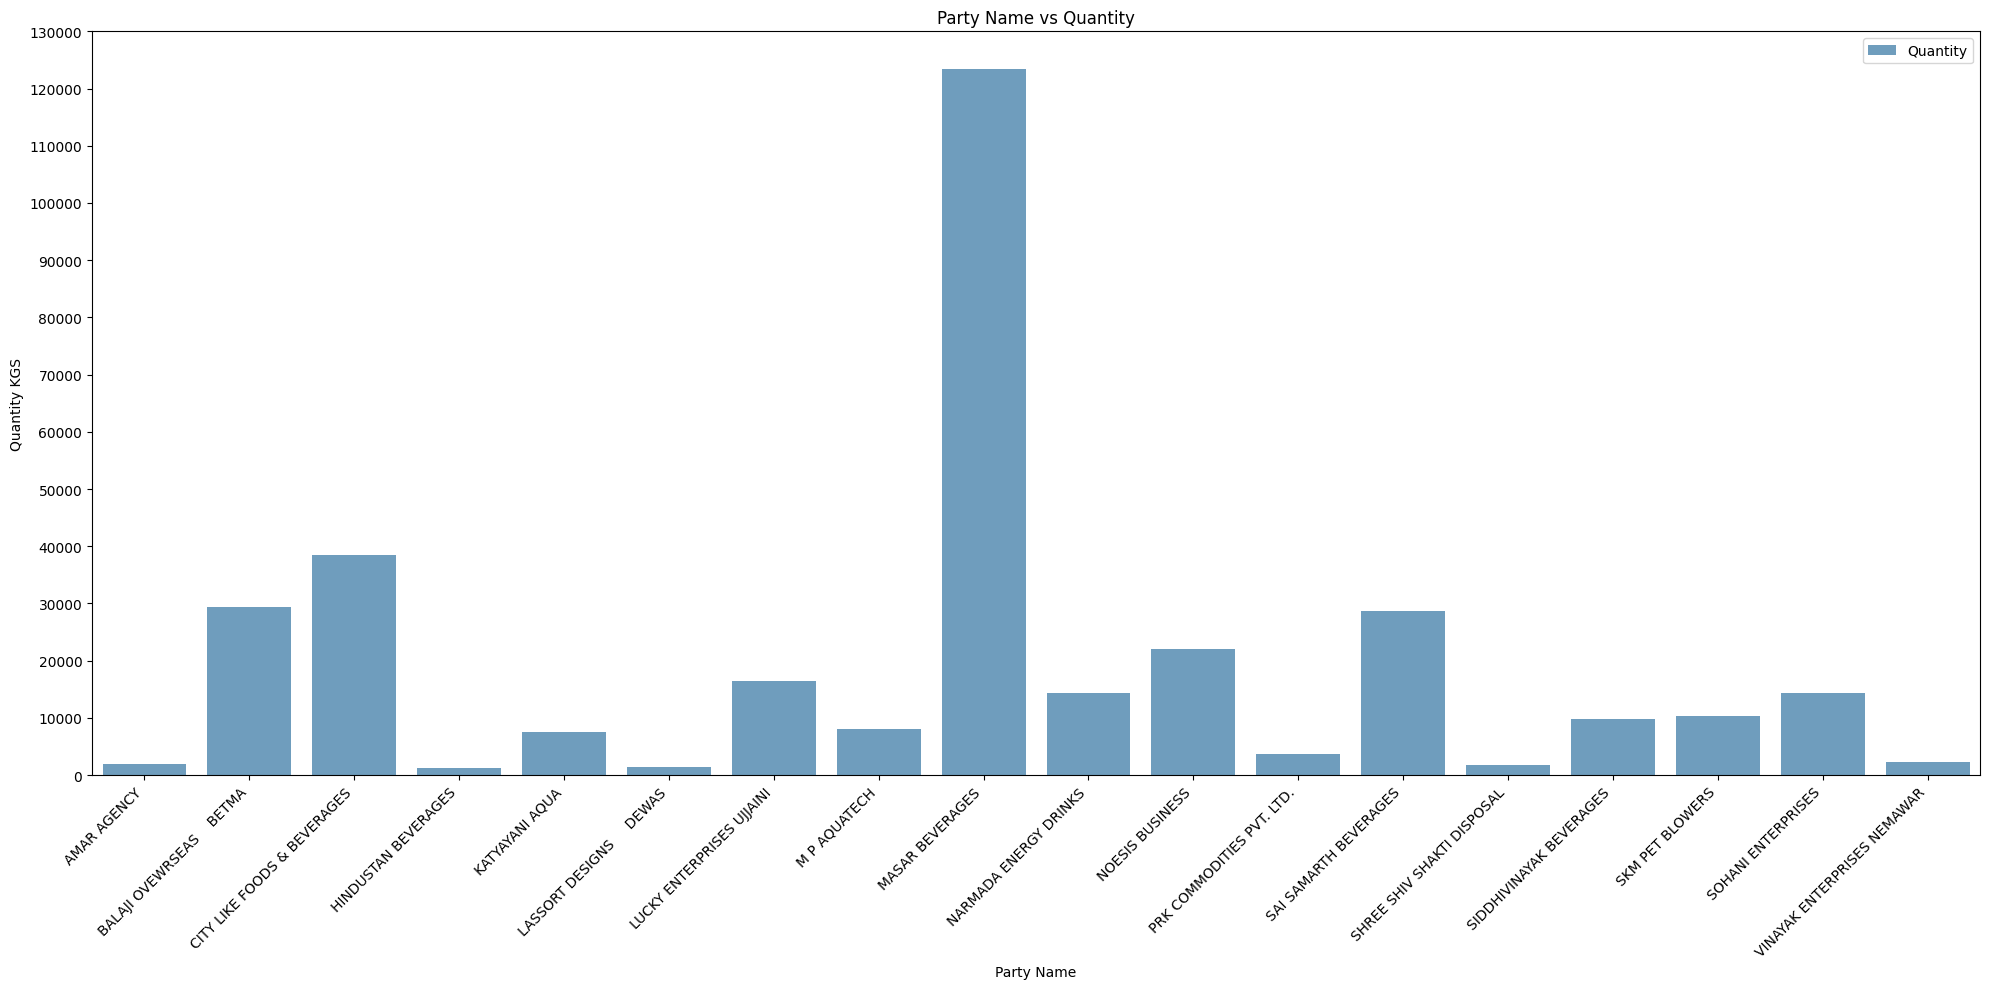

In [8]:
selected_year = 2024
party_grp = df[df['Year'] == selected_year].groupby(['PARTY NAME'])['Quantity'].sum().reset_index()
party_grp = party_grp[party_grp['Quantity'] > 1000]



plt.figure(figsize=(20, 10))
sns.barplot(x='PARTY NAME', y='Quantity', data=party_grp, alpha=0.7, label='Quantity')
plt.xticks(rotation=45, ha='right')
y_ticks = np.arange(0, yearly_grp['Quantity'].max() + 10000, 10000) 
plt.yticks(y_ticks)
plt.xlabel('Party Name')
plt.ylabel('Quantity KGS')
plt.title('Party Name vs Quantity')
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion from this graphical analysis


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = monthly_grp['DATE'].apply(lambda x: x.to_timestamp().timestamp()).values.reshape(-1, 1)
y = monthly_grp['Quantity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print("MAE for linear regression: ",mean_absolute_error(y_test,y_pred_lr))


MAE for linear regression:  9579.643868482617


In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Apply polynomial features of degree 2 (can experiment with degree)
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polynomial_model.fit(X_train, y_train)
y_pred_poly = polynomial_model.predict(X_test)

print("MAE for polynomial regression: ",mean_absolute_error(y_test, y_pred_poly))

MAE for polynomial regression:  9829.740507797722


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)
y_pred_rf = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", mae)

print("OOB Score:", regressor.oob_score_)

Mean Absolute Error: 5136.292352941176
OOB Score: 0.4401947440741283
